# UNIVERSIDAD NACIONAL DE CÓRDOBA#
## Fa.M.A.F – Observatorio Astronómico ##
### Licenciatura en Astronomía ###
### Tapia Martina ###
### Astrometría 2020 ###
## Práctico N° 4: Inferencia Bayesiana con métodos MonteCarlo: Cadenas de Markov##

## Introducción ##

En este trabajo se implementarán distintos conceptos y técnicas relacionados con la inferencia estadística, ajuste de funciones, selección de modelos, cuadrados mínimos, interpolación y minimización.  
El *objetivo* es realizar inferencia Bayesiana, para lograr el ajuste de un modelo paramétrico a un conjunto de datos dados. Para ello se realizará la exploración del espacio de parámetros para estimar la función de Likelihood usando Cadenas de Markov Monte Carlo (MCMC). Luego, se implementará el algoritmo de Metrópolis-Hastings para llevar a cabo realizaciones de MCMC. También se interpolaron los datos para construir una función contínua y derivable que pase por el conjunto de puntos. Finalmente, se minimizarán funciones, mediante la técnica del gradiente descendente. Es importante notar que para lograr todos éstos objetivos se implementarán varias funciones en Python.  

### Conceptos Básicos ###  

Antes de comenzar, es fundamental repasar algunos conceptos básicos que se usaran constantemente en el desarrollo del trabajo. 
En primer lugar, la inferencia estadística se puede llevar a cabo como una aplicación del teorema de Bayes. Si se tiene un conjunto de datos **d** que se puede describir por un modelo **m** con parámetros **$\phi$**, se quiere calcular el mejor modelo que puede dar lugar a esos datos, es decir, maximizar la probabilidad posterior de los parámetros dados los datos
para un modelo **m**, $p(\phi |d, m)$. Esta probabilidad es proporcional al Likelihood $p(d|\phi, m)$ por la función distribución de la probabilidad anterior $(prior, p(\phi, m))$.  

$$ p(\phi|d, m) = \frac{p(d|\phi,m)*p(\phi|m)}{p(d|m)}    $$

y está normalizada por la *evidencia*, es decir, la probabilidad marginal del Likelihood para el modelo **m**:

$$ \int_{\Omega}p(d|\phi,m)p(\phi|m)d\phi $$

donde $\Omega$ denota el espacio de parámetros.  

Cuando se ajusta un modelo a un conjunto de datos, se quiere conocer la función de Likelihood, p(d|φ, m), que depende de los parámetros $\phi $. Existen varios métodos para llevar esto a cabo, entre ellos las Cadenas de Markov Monte Carlo (MCMC). En particular, el algoritmo de Metrópolis-Hastings es un método de MCMC que se utiliza para simular distribuciones multivariadas.



## Actividad 1 ##

Como primer paso para realizar este trabajo, se graficaran los datos pertenecientes a la función de luminosidad de galaxias obtenida por Blanton et al.(2001). Los datos correspondientes a la función de luminosidad se descargaron del aula virtual de la materia.


In [1]:
#Primero se importan las librerías necesarias para trabajar
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import seaborn as sns        
from scipy import stats as st
import functools
sns.set()

In [2]:
# Se importan los datos y sus errores, para ser usados en el notebook
datos = np.genfromtxt('datos2.dat',delimiter=',')
einf = np.genfromtxt('errores_inferiores.dat', delimiter = ',')
esup = np.genfromtxt('errores_superiores.dat', delimiter = ',')

In [3]:
x = datos[:,0]
y = datos[:,1]

In [4]:
ei = einf[:,1]
es = esup[:,1]

In [5]:
e1 = y- ei
e2 = es - y

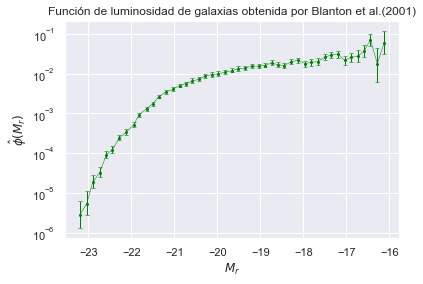

In [6]:
#Se grafica la función luminosidad de galaxias con las barras de error correspondientes

plt.title('Función de luminosidad de galaxias obtenida por Blanton et al.(2001)')
plt.xlabel('$M_{r}$')
plt.ylabel('$\hat \phi(M_{r})$')
plt.yscale('log')
plt.errorbar(x,y, yerr =(e1,e2),marker ='o', markersize=2, color='green',ecolor ='green',elinewidth=1,linewidth=0.5)
plt.plot(x,ei, '_g', markersize=4, )
plt.plot(x, es, '_g', markersize=4)
plt.show()

## Actividad 2 ##

En ésta actividad, se desea ajustar el modelo **m** al conjunto de datos **d**, mediante un análisis Bayesiano. Para el caso de los datos de la actividad 1, se utilizará como modelo la función de **Schechter**:


$$ \Phi(M)dM = 0.4 * \ln(10)* \Phi_{*}* 10^{-0.4( M - M_{*})*(\alpha + 1 )} * e^{-10^{-0.4*(M-M_{*})}}dM $$  

Los parámetros que se intentan determinar son $\Phi_{*}$ , $M_{*}$ y $\alpha$. Para ello, se escribirá en python las siguientes funciones:
- la función de likelihood
- la función de priors
- la función de probabilidad posterior  

Estas funciones se necesitarán cuando se explore el espacio de parámetros.   

Lo que se busca es *determinar* claramente los parámetros de entrada y de salida de estas funciones e implementarlas en un programa. Luego, utilizando estas funciones, se usará el algoritmo de *Metróopolis-Hastings* para explorar el espacio de parámetros. Los parámetros del algoritmo son el largo de la cadena (un núumero entero) y las funciones prior. Se debe tener en cuenta que los priors contienen el conocimiento previo sobre los datos. Los priors más comunes son funciones planas y funciones gaussianas.  
Por último, se  explicará qué parámetros intervienen, cómo y porqué se eligen sus valores y se experimentará con distintas funciones de prior evaluando su impacto en la realización de las cadenas.

In [7]:
#Se define una función que represente el modelo de Schechter

def model_Sche(phi0, M0, a, M):
    
    phi1 = []
    for i in range(len(M)):
        
        b = -0.4*(M[i]-M0)*(a+1)
        c = -0.4*(M[i]-M0)
        phi = 0.4 * math.log(10) * phi0 * 10**b * math.exp(-10**c)
        phi1.append(phi)
    
    return(phi1)

In [8]:
#Se verifica si el modelo funciona
M1= np.linspace(-16,-23,100)
y1a = model_Sche(phi0=1.46E-2,M0=-20.83,a=-1.20,M=M1)

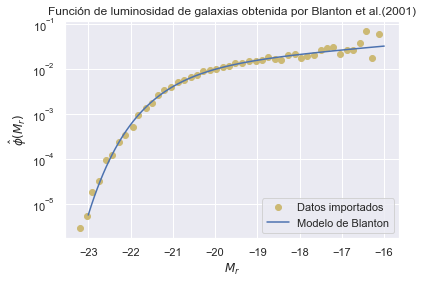

In [9]:
#Se grafica el modelo sobre los puntos para verificar la función modelo

plt.title('Función de luminosidad de galaxias obtenida por Blanton et al.(2001)')
plt.xlabel('$M_{r}$')
plt.ylabel('$\hat \phi(M_{r})$')
plt.yscale('log')
plt.yscale('log')
plt.plot(x,y, 'oy', label='Datos importados')
plt.plot(M1,y1a, label='Modelo de Blanton')
plt.legend(loc='lower right')
plt.show()

### Likelihood ###

Considerando algún modelo de error, la función de *likelihood* indica qué tan bien reproducen los datos a las predicciones del modelo. Su expresión es:  

$$p(d|\phi,m) =  \prod_{i=1}^{N} p((M_i, \phi_i) | \phi_{*},M_{*}, \alpha)$$  

Para calcular cada $ p((M_i, \phi_i) | \phi_{*},M_{*}, \alpha)$ se asumen errores gaussianos.

In [10]:
#Se calcula el sigma de los datos, usando las barras de error
s = (es - ei)/2

In [11]:
def likelihood(datax, datay, phi0, M0, a, sig):
    
    phi_model = model_Sche(phi0,M0,a,datax)
    p = st.norm(loc=phi_model, scale=sig).pdf(datay)
    l = p.prod()
    return(l)

In [12]:
#Se comprueba que con los valores de los parámetros de Blanton el likelihood es muy grande

likelihood(datay=y, phi0=1.46E-2,M0=-20.83,a=-1.20,datax=x,sig=s)

4.529434606468913e+121

Notar que el valor obtenido de likelihood es muy alto, lo que dice que los datos reproducen muy bien las predicciones del modelo, que es lo se espera que suceda. 

### Priors ###

Los priors son la información previa que se tiene sobre el modelo. Si se supone que no se conoce nada del modelo, entonces se usan priors lo más "agnósticos" posible: que todos los valores en cierto rango tienen la misma probabilidad.  
En este caso, se buscará estimar los valores límite de los parámetros del modelo variando los parámetros y observando gráficamente. 

In [13]:
#Se crea un arreglo de valores de magnitud para graficar las pruebas
M1= np.linspace(-16,-23,100)

In [14]:
# En este paso se dejan fijos dos de los parámetros y se varía el tercero

y1 = model_Sche(phi0=0.5E-2,M0=-20.83,a=-1.20,M=M1)
y2 = model_Sche(phi0=4.46E-2,M0=-20.83,a=-1.20,M=M1)
y3 = model_Sche(phi0=1.46E-2,M0=-22,a=-1.20,M=M1) #azul
y4 = model_Sche(phi0=1.46E-2,M0=-19,a=-1.20,M=M1) #naranja
y5 = model_Sche(phi0=1.46E-2,M0=-20.83,a=-1.9,M=M1)
y6 = model_Sche(phi0=1.46E-2,M0=-20.83,a=-0.001,M=M1)

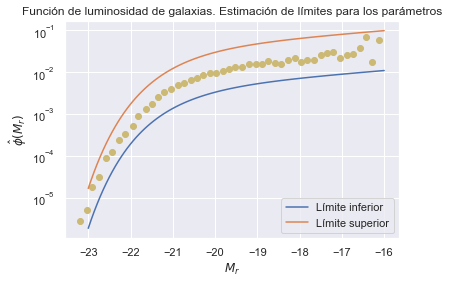

In [15]:
#Al graficar, se verifica que los datos medidos queden 'dentro' de los modelos que contienen los límites de los parámetros
#Se deja graficado el modelo con la variacion del parámetro phi0 a modo de ejemplo y comentados los otros parámetros
plt.title('Función de luminosidad de galaxias. Estimación de límites para los parámetros')
plt.xlabel('$M_{r}$')
plt.ylabel('$\hat \phi(M_{r})$')
plt.yscale('log')
plt.plot(x,y, 'oy')
plt.plot(M1,y1, label = 'Límite inferior')
plt.plot(M1,y2, label = 'Límite superior')
#plt.plot(M1,y3)
#plt.plot(M1,y4)
#plt.plot(M1,y5)
#plt.plot(M1,y6)
plt.legend(loc='lower right')
plt.show()

Como los parámetros no son independientes entre si, para ver si los límites que se proponen son correctos, se consideran todos los modelos extremos dados por esos parámetros límites.

In [16]:
#Se determinan todos los modelos combinando los valores límites de los parámetros

y1 = model_Sche(phi0=0.5E-2,M0=-22,a=-1.9,M=M1)
y2 = model_Sche(phi0=4.46E-2,M0=-22,a=-1.9,M=M1)
y3 = model_Sche(phi0=0.5E-2,M0=-22,a=-0.1,M=M1) #azul
y4 = model_Sche(phi0=4.46E-2,M0=-22,a=-0.1,M=M1) #naranja
y5 = model_Sche(phi0=0.5E-2,M0=-19,a=-1.9,M=M1)
y6 = model_Sche(phi0=4.46E-2,M0=-19,a=-1.9,M=M1)
y7 = model_Sche(phi0=0.5E-2,M0=-19,a=-0.001,M=M1)
y8 = model_Sche(phi0=4.46E-2,M0=-19,a=-0.001,M=M1)

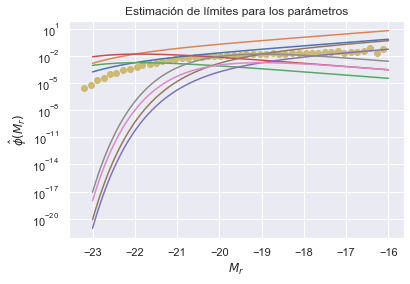

In [17]:
#Se grafican las combinaciones para verificar que los datos se encurntren dentro del cubo de posibilidades

plt.title('Estimación de límites para los parámetros')
plt.xlabel('$M_{r}$')
plt.ylabel('$\hat \phi(M_{r})$')
plt.yscale('log')
plt.plot(x,y, 'oy')
plt.plot(M1,y1)
plt.plot(M1,y2)
plt.plot(M1,y3)
plt.plot(M1,y4)
plt.plot(M1,y5)
plt.plot(M1,y6)
plt.plot(M1,y7)
plt.plot(M1,y8)


plt.show()

Una vez determinados los límites, al menos en primera instancia, lo que se hace es definir una función **prior**. Esta función representa la 'probabilidad a priori' para los parámetros, es decir, los valores permitidos para los parámetros de este modelo. Es el conocimiento previo, por lo que se usa la información disponible para estimar éstos intervalos y luego, a medida que se avance en el proceso, se buscará mejorar su elección. 

In [18]:
#Se define la función prior
#En este caso, los valores dentro de 'scale' determinarán el salto que se hace desde los puntos 'loc' para 
#la determinación del intervalo donde la función es distinta de cero. 
#El subíndice 'inc' hace referencia a 'incremento'

def prior(phi, m, a, phi0_inf = 0.5E-2 , M0_inf = -22, a_inf = -1.9, phi0_inc = 0.0396, M0_inc = 3 , a_inc = 1.899):
    
    f = st.uniform(loc = [phi0_inf, M0_inf, a_inf], scale = [phi0_inc, M0_inc, a_inc])
    p = f.pdf([phi, m, a]).prod()
    
    return(p)
    

In [19]:
#Se prueba la función creada para los valores de los parámetros determinados por Blanton 
#Se debe conprobar que la función prior sea distinta de cero
prior(1.46E-2, -20.83, -1.20)

4.432600535812751

In [20]:
#Se verifica que la función trabaje correctamente 
#Se le da un valor de phi fuera del intervalo definido en la funcion
#Se debería comprobar que el prior da cero
prior(7.5E-2, m=-21, a = -1.1)

0.0

In [21]:
#Se le da un valor de phi dentro del intervalo de validez
a = prior(0.9E-2, m=-21, a = -1.1)
b = prior(2.0E-2, m=-21, a = -1.1)
a, b

(4.432600535812751, 4.432600535812751)

Se comprueba que para dos valores diferentes de phi (que pertenecen al intervalo) el valor del prior es el mismo.  
Para verificar de mejor manera que para todos los valores, pertenecientes a los intervalos de validez, obtienen el mismo valor de prior se graficaran los resultados para visualizarlo de mejor manera.

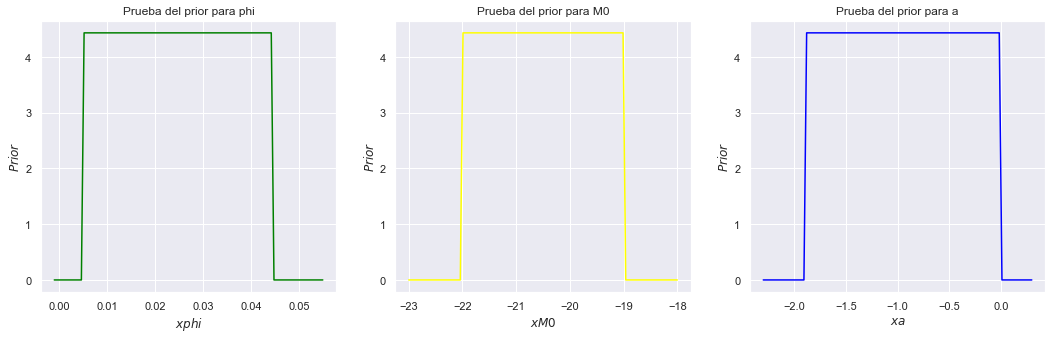

In [22]:
#Se crea un conjunto de valores que pertenecen y otros que no al intervalo de validez de phi 

plt.figure(figsize=(18,5))
xphi = np.linspace(-0.1E-2,5.5E-2,100)
yphi = []
for i in range(100):
    yphi1 = prior(xphi[i], m = -21, a = -1.1)
    yphi.append(yphi1)
    
plt.subplot(1,3,1)    
plt.title('Prueba del prior para phi')
plt.xlabel('$xphi$')
plt.ylabel('$Prior$')    
plt.plot(xphi, yphi, color= 'green')

#Se crea un conjunto de valores que pertenecen y otros que no al intervalo de validez de M0

plt.subplot(1,3,2)
xM0 = np.linspace(-23,-18,100)
yM0 = []
for i in range(100):
    yM01 = prior(2.0E-2, xM0[i], a = -1.1)
    yM0.append(yM01)
    
plt.title('Prueba del prior para M0')
plt.xlabel('$xM0$')
plt.ylabel('$Prior$')    
plt.plot(xM0, yM0, color= 'yellow')


#Se crea un conjunto de valores que pertenecen y otros que no al intervalo de validez de alpha

plt.subplot(1,3,3)
x_a = np.linspace(-2.3,0.3,100)
y_a = []
for i in range(100):
    y_a1 = prior(phi = 2.0E-2, m = -21, a = x_a[i])
    y_a.append(y_a1)
    
plt.title('Prueba del prior para a')
plt.xlabel('$xa$')
plt.ylabel('$Prior$')    
plt.plot(x_a, y_a, color= 'blue')
plt.show()

Se puede comprobar que para los tres parámetros los resultados del prior son lo que se buscaba. 

### Probabilidad Posterior ###

A continuación se busca definir una función que calcule la 'probabilidad a posteriori' de los parámetros dados los datos y el modelo. Usando el teorema de Bayes (definido en la introducción) se puede deducir que cuando se tiene el likelihood y el prior pero no se tiene la 'evidencia' la probabilidad posterior se puede aproximar por:

$$ p(\phi|d, m) = p(d|\phi,m)*p(\phi|m) $$

 Además, si el modelo **m** se mantiene fijo, como es en éste caso, se obtiene: 
 
$$ p(\phi|d) = p(d|\phi)*p(\phi) = \Pi(\phi)$$

In [23]:
#Se define la función posterior usando el likelihood y el prior definidos anteriormente.

def post(datax, datay, phi0, M0, a, sig):
    
    post = likelihood(datax,datay,phi0,M0,a,sig) * prior(phi0, M0, a)
    return(post)

In [24]:
#Se prueba con los parámetros de Blanton
#Se tiene que verificar que no resulte ser cero 
post(x, y, phi0 = 1.46E-2, M0 = -20.83, a = -1.20, sig = s)

2.0077174263562922e+122

### Implementación del algoritmo de Metrópolis-Hastings ###

El procedimiento de Metrópolis un método simple, que copia la manera en la cual sistemas físicos, en equilibrio térmico, pueblan su función de distribución. El procedimiento esta basado en 2 ideas:  

- La primera es que se debería tratar de muestrear $\Pi(\phi)$ no a través de puntos independientes sin relación, sino a través de una Cadena de Markov, una secuencia de puntos $~\phi_{0}, \phi_{1},.... $ que, aunque localmente correlacionados, pueden pasear eventualmente por cada punto $\phi$ en proporción a $\Pi(\phi)$ (propiedad ergódica). La palabra Markov significa que cada punto $\phi_{i}$ se elige de una distribución que sólo depende del valor del punto inmediatamente anterior $\phi_{i-1}$. En otras palabras, la cadena tiene una memoria que sólo se extiende hasta su punto anterior y está completamente definida por una función de probabilidad de transición de 2 variables, $p(\phi_{i}|\phi_{i-1})$, la probabilidad con la que $\phi_{i}$ es elegido dado el punto previo $\phi_{i-1}$.  

- La segunda idea es que $p(\phi_{i}|\phi_{i-1})$ se elige tal que satisfaga la ecuación del balance detallado, es decir,  
$$ \Pi(\phi_{1})*p(\phi_{2}|\phi_{1}) = \Pi(\phi_{2})*p(\phi_{1}|\phi_{2})$$ 
usualmente interpretada como un “equilibrio térmico”. Entonces, la cadena de Markov muestreará $\Pi(\phi)$ ergódicamente (es decir, cada estado puede alcanzarse desde cualquier otro estado). Esta condición expresa la idea de “equilibrio físico” en la transición reversible $\phi_{1} -->\phi_{2} $. Es decir, si $\phi_{1}$ y $\phi_{2}$ ocurren en proporción a $\Pi(\phi_{1})$ y $\Pi(\phi_{2})$ respectivamente, entonces las tasas generales de transición en cada dirección, es decir, cada producto de densidad de población y probabilidad
de transición, son iguales.  

Hasta aquí, se necesita entonces una función de transición $p(\phi_{2}|\phi_{1})$ que cumpla con la ecuación de balance detallado. Sino se la tiene, no se tiene manera de aplicar el método. Por suerte, Hastings generalizó el trabajo de Metropolis, dando una receta general que se seguirá para realizar la cadena:  

- Se debe elegir una distribución de propuesta (proposal) $q(\phi_{2}|\phi_{1})$. Esta puede ser lo que se desee siempre que los pasos generados por ella, alcancen cualquier región de interés.  
- A partir de $\phi_{1}$, se debe generar un candidato $\phi_{2c}$ usando $q(\phi_{2}|\phi_{1})$.  
- Luego, se calcula la probabilidad de aceptación, $\alpha(\phi_{1},\phi_{2c})$, usando:  

$$ \alpha(\phi_{1},\phi_{2c}) = min[1, \frac{\Pi(\phi_{2c})*q(\phi_{1}|\phi_{2c})}{\Pi(\phi_{1})*q(\phi_{2c}|\phi_{1})}]$$  

- Se genera un número aleatorio uniforme, $u_{i}$ (entre 0 y 1), y se compara con $\alpha$;  
* Si $u_{i} < \alpha $, se acepta el punto candidato y se pone $\phi_{2} = \phi_{2c}$.  
* Si $u_{i} > \alpha$, se rechaza y se deja el punto inalterado,  $\phi_{2} = \phi_{1}$.  

El resultado neto de este proceso es una probabilidad de transición:

$$p(\phi_{2}|\phi_{1}) = q(\phi_{2}|\phi_{1})*\alpha(\phi_{1}|\phi_{2})$$  

Puede verse que esta ecuación satisface la ecuación de balance detallado.  


A continuación, se aplicarán éstos pasos detallados comenzando con la definición de la función 'proposal'. Esta distribution es lo que se propone como 'salto' de parámetros. Se asume una distribución gaussiana centrada en el paso anterior y el sigma depende del parámetro. Determinar los valores de sigma, se realizó a prueba y error hasta lograr la convergencia de la cadena. 


In [25]:
#Se define la Proposal 

phisig = 0.00002
msig = 0.0002
alpsig = 0.002


proposal = functools.partial(np.random.multivariate_normal, cov = [[phisig, 0 , 0], [0, msig, 0], [0, 0, alpsig] ])
    

In [26]:
#Se prueba que funciona 

proposal([0, 1,0])

array([0.0012255 , 0.98658881, 0.04024781])

In [27]:
#Se realiza una cadena 

datax = x
datay = y
posterior = 0
while posterior < 1.E-8:        # Se quiere iniciar la cadena, dentro del 'cubo' de los valores permitidos para los parámetros
                                
    phi0_inicial = random.uniform(0.5E-2, 4.46E-2)
    m0_inicial = random.uniform(-22, -19)
    a0_inicial = random.uniform(-1.9, -0.001)
    
    
    posterior = post(datax = datax, datay = datay, phi0 = phi0_inicial, M0 = m0_inicial, a = a0_inicial, sig = s)


cadena_phi0 = []
cadena_m0 = []
cadena_a0 = []

Npasos = 30000

for i in range(Npasos):
    
    phi0_new, m0_new, a0_new = proposal([phi0_inicial, m0_inicial, a0_inicial])
    
    posterior_new = post(datax, datay, phi0_new, m0_new, a0_new, sig=s)
    
    prob_aceptacion = min(1, posterior_new / posterior)
    
    u = random.random()
    acepto = u < prob_aceptacion
    
    if acepto:
        
        phi0_inicial = phi0_new
        m0_inicial = m0_new
        a0_inicial = a0_new
        posterior = posterior_new
   
    cadena_phi0.append(phi0_inicial)
    cadena_m0.append(m0_inicial)
    cadena_a0.append(a0_inicial)
    


Al realizarse la cadena, se tuvieron varios inconvenientes para que la misma converja. Fue muy complicado lograr determinar los valores en cierta medida 'correctos'. Tanto el ancho de los intervalos de los parámetros definidos en la función prior, los sigmas dados dados como pasos y el número de pasos influyeron notablemente en las decisiones tomadas.Fue necesario correlacionar  el tamaño del salto y el ancho del intervalo hasta lograr el correcto funcionamiento. Además, el número de pasos, se fue aumentando paulatinamente, una vez eliminados los errores del programa.

Después de renegar mucho, obtener cadenas sin converger y solucionar muchos errores en el lazo, se logró converger la cadena. Fue muy importante la ayuda de los compañeros de clase y del profesor en esta parte del trabajo.  

Luego, para comprobar este correcto funcionamiento, se realizarán distintos gráficos acontinuación.  
Primero, se grafica cada parámetro vs  otro parámetro:

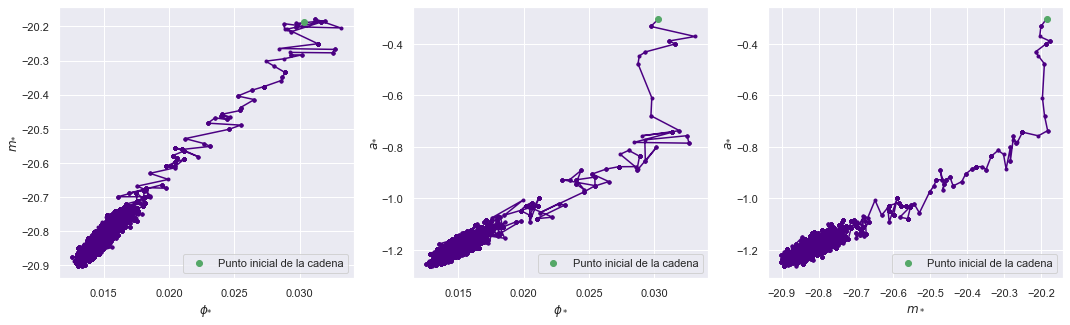

In [28]:
#Se grafican los parámetros 

plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(cadena_phi0, cadena_m0, marker='.', color = 'indigo')
plt.plot(cadena_phi0[0], cadena_m0[0], 'og', label='Punto inicial de la cadena') 
plt.legend(loc='lower right')
plt.xlabel('$\phi_{*}$')
plt.ylabel('$m_{*}$')

plt.subplot(1,3,2)
plt.plot(cadena_phi0, cadena_a0, marker='.', color = 'indigo')
plt.plot(cadena_phi0[0], cadena_a0[0], 'og', label='Punto inicial de la cadena')
plt.legend(loc='lower right')
plt.xlabel('$\phi_*$')
plt.ylabel('$a_{*}$')

plt.subplot(1,3,3)
plt.plot(cadena_m0, cadena_a0, marker='.', color = 'indigo')
plt.plot(cadena_m0[0], cadena_a0[0], 'og', label='Punto inicial de la cadena')
plt.legend(loc='lower right')
plt.xlabel('$m_*$')
plt.ylabel('$a_{*}$')

plt.show()

Notar que en los tres gráficos obtenidos se visualiza una acumulación de los puntos centrada aproximadamente en los valores obtenidos por Blanton para cada parámetro.  
A continuación, se graficarán los parámetros en función de los pasos de la cadena;

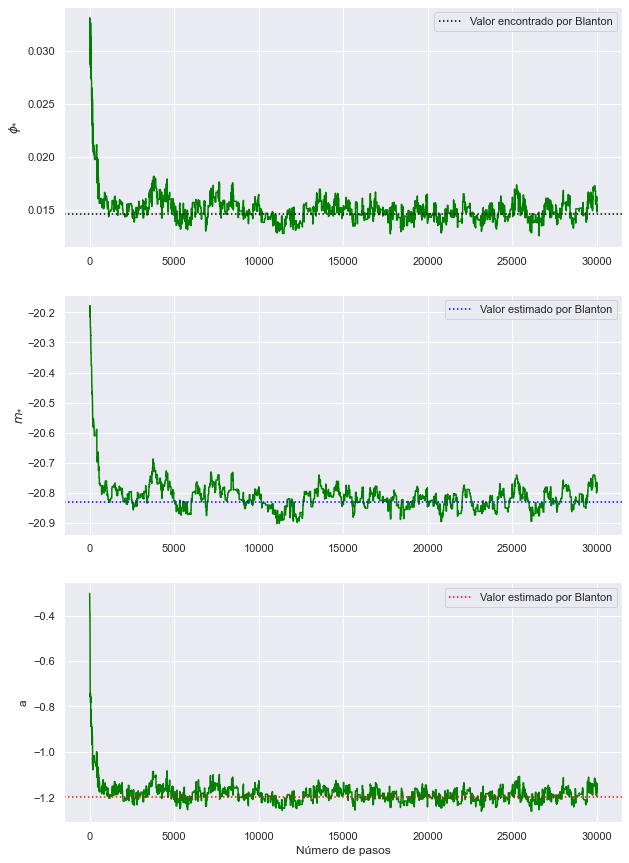

In [29]:
#Se grafica 
plt.figure(figsize=(10,15))

plt.subplot(3,1,1)
plt.plot(cadena_phi0, color= 'green')
plt.axhline(0.0146, color='black', label='Valor encontrado por Blanton', ls="dotted") 
plt.legend(loc='upper right')
plt.ylabel('$\phi_{*}$')

plt.subplot(3,1,2)
plt.plot(cadena_m0, color = 'green')
plt.axhline(-20.83, color='blue', label='Valor estimado por Blanton', ls="dotted")
plt.legend(loc='upper right')
plt.ylabel('$m_{*}$')

plt.subplot(3,1,3)
plt.plot(cadena_a0, color ='green')
plt.axhline(-1.2, color='red', label='Valor estimado por Blanton', ls="dotted")
plt.legend(loc='upper right')
plt.xlabel('Número de pasos')
plt.ylabel('a')
plt.show()

Notar que los parámetros generados por el método Metrópolis- Hastings, muestran una correlación serial. Los números dependerán de como comenzó el algoritmo, aunque después de un rato su memoria se perderá. El periodo donde las condiciones iniciales todavía importan se llama 'periodo de ablande' o 'burn-in' en españo, 'quemado'. Al comienzo de cada cadena graficada se visualiza claramente éste tramo donde las condiciones iniciales son importantes, en este caso, aproximadamente hasta el paso 2500 se extiende el quemado.  
Estos valores (antes del 'burn-in') deben eliminarse de la cadena para así estimar el valor del parámetro correctamente. Para obtener el parámetro buscado, se estima el valor de expectación con los parámetros obtenidos.

In [38]:
#Se cortarán las cadenas a partir de Npasos = 2500 

burn_in = 2500
burnin_phi0 = cadena_phi0[2500:]
burnin_m0 = cadena_m0[2500:]
burnin_a0 = cadena_a0[2500:]

In [31]:
#Se calcula el promedio de cada parámetro

phi0_promedio = np.mean(burnin_phi0)
m0_promedio = np.mean(burnin_m0)
a0_promedio = np.mean(burnin_a0)

print('El phi0 promedio =', phi0_promedio)
print('m0 promedio =', m0_promedio)
print('a0 promedio =', a0_promedio)

El phi0 promedio = 0.014900017337999163
m0 promedio = -20.818626674005973
a0 promedio = -1.1897597031856282


Finalemnete, se puede ver que los valores obtenidos son muy parecidos a los encontrados por Blanton, por lo que la cadena realizada podría ser un buen estimador de los parámetros. 

## Actividad 3 ##

En ésta actividad se busca visualizar las propiedades de convergencia de las cadenas, encontrando condiciones de la simulación para las cuales se produce un mal y un buen mezclado (mixing) de las cadenas. Para ello se realizarán varias cadenas y se compararán.  

Para realizar varias cadenas, se usa lo programado anteriormente. El objetivo es hacer un loop para que se ejecute varias veces la cadena. 

In [49]:
#Primero se crean nuevas listas para guardar los parámetros de cada cadena

cadenas_phi0=[] 
cadenas_m0=[]
cadenas_a0=[]

#Se usa un for para hacer la cantidad de cadenas que se desee, en este caso se eligen 10 cadenas

n_cadenas = 5

for j in range(n_cadenas):
    
    posterior1 = 0
    while posterior1 < (1.e-8): 
        phi0_inic1=random.uniform(0.5E-2, 4.46E-2)
        m0_inic1=random.uniform(-22, -19)
        a0_inic1=random.uniform(-1.9, -0.001)
        posterior1= post(datax = datax, datay = datay, phi0 = phi0_inic1, M0 = m0_inic1, a = a0_inic1, sig = s)
    
    cadena_phi01= [phi0_inic1]
    cadena_m01= [m0_inic1]
    cadena_a01= [a0_inic1]
    
    N_pasos1 = 30000
    
    for i in range(N_pasos1):
        phi0_new1, m0_new1, a0_new1= proposal([phi0_inic1, m0_inic1, a0_inic1])
        posterior_new1= post(datax = datax, datay = datay, phi0 = phi0_new1, M0 = m0_new1, a = a0_new1, sig = s)
        
        prob_aceptacion1 = min(1, posterior_new1 / posterior1)
        u1 = random.random()
        if u1 < prob_aceptacion1 : 
            phi0_inic1= phi0_new1
            m0_inic1 = m0_new1
            a0_inic1 = a0_new1
            posterior1 = posterior_new1
        cadena_phi01.append(phi0_inic1)
        cadena_m01.append(m0_inic1)
        cadena_a01.append(a0_inic1)
        
    
    cadenas_phi0.append(cadena_phi01)
    cadenas_m0.append(cadena_m01)
    cadenas_a0.append(cadena_a01)

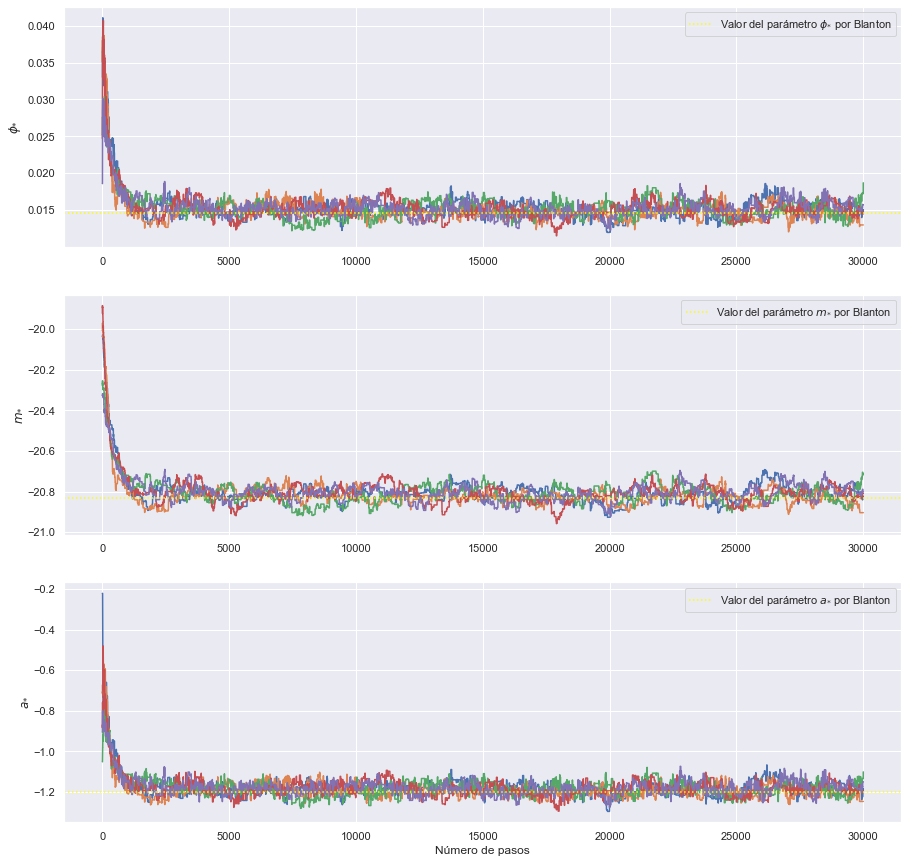

In [50]:
#Se graficarán todas las cadenas realizadas

plt.figure(figsize=(15,15))

plt.subplot(3,1,1)
for i in range(len(cadenas_phi0)):
    plt.plot(cadenas_phi0[i])
    plt.ylabel('$\phi_{*}$')
plt.axhline(0.0146, color='yellow', label='Valor del parámetro $\phi_{*}$ por Blanton', ls="dotted") 
plt.legend(loc='upper right')

plt.subplot(3,1,2)
for i in range(len(cadenas_m0)):
    plt.plot(cadenas_m0[i])
    plt.ylabel('$m_{*}$')
plt.axhline(-20.83, color='yellow', label='Valor del parámetro $m_{*}$ por Blanton', ls="dotted")
plt.legend(loc='upper right')


plt.subplot(3,1,3)
for i in range(len(cadenas_a0)):
    plt.plot(cadenas_a0[i])
    plt.ylabel('$a_{*}$')
    plt.xlabel('Número de pasos')
plt.axhline(-1.2, color='yellow', label='Valor del parámetro $a_{*}$ por Blanton', ls="dotted")
plt.legend(loc='upper right')

plt.show()

Notar que las cadenas graficadas convergen alrededor del mismo valor, además éste valor es muy similar al propuesto por Blanton. Nuevamente, se ve que el "burn-in" ocurre en los los 2500 pasos. 

In [53]:
#Se vuelven a calcular los promedios para parámetro
#Antes, se cortan las cadenas para evitar el tramo 'burn-in'
#Se realizan listas, para guardar los promedios de cada cadena 

phi0_promedios = []
m0_promedios = []
a0_promedios = []

n_cadenas = 5
for i in range(n_cadenas):     
    
    burnin_phi01 =  cadenas_phi0[i][2500:]
    burnin_m01 = cadenas_m0[i][2500:]
    burnin_a01 = cadenas_a0[i][2500:]
        
    phi0_promedio1 = np.mean(burnin_phi01)
    m0_promedio1 = np.mean(burnin_m01)
    a0_promedio1 = np.mean(burnin_a01)
    
    phi0_promedios.append(phi0_promedio1)
    m0_promedios.append(m0_promedio1)
    a0_promedios.append(a0_promedio1)  


In [54]:
#Se visualizarán los resultados a continuación
#Antes, se realiza un promedio de los promedios (no es muy conveniente pero al menos es una aproximación del valor)

phi0_final=np.mean(phi0_promedios)
m0_final=np.mean(m0_promedios)
a0_final=np.mean(a0_promedios)

print('El valor del parámetro es phi0=', phi0_final)
print('El valor del parámetro es m0 =', m0_final)
print('El valor del parámetro es a0=', a0_final)

El valor del parámetro es phi0= 0.014968486788559129
El valor del parámetro es m0 = -20.815620476133383
El valor del parámetro es a0= -1.1878986936109799


Una vez que se obtuvieron los valores de los parámetros, se usará la función del modelo de Schechter con estos parámetros y se graficará en conjunto con los datos iniciales para ver como se comportan:

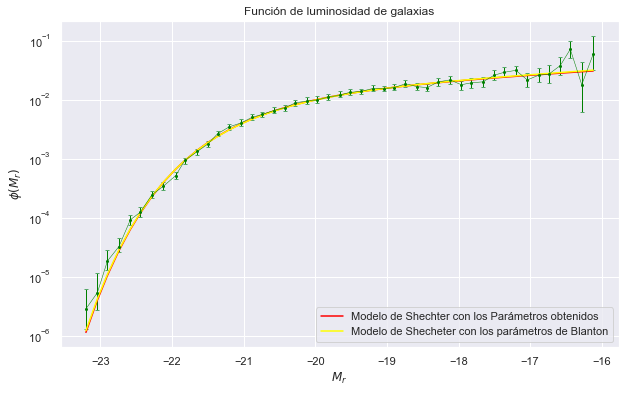

In [60]:
#Se grafican los datos como en el inicio. 

plt.figure(figsize=(10,6))

plt.title('Función de luminosidad de galaxias')
plt.xlabel('$M_{r}$')
plt.ylabel('$\hat \phi(M_{r})$')
plt.yscale('log')
plt.errorbar(x,y, yerr =(e1,e2),marker ='o', markersize=2, color='green',ecolor ='green',elinewidth=1,linewidth=0.5)
plt.plot(x,ei, '_g', markersize=4, )
plt.plot(x, es, '_g', markersize=4)

#Primero se calcula el modelo con los nuevos parámetros

yf = model_Sche(phi0=phi0_final,M0=m0_final,a=a0_final,M=x)
plt.plot(x, yf, color='red', label='Modelo de Shechter con los Parámetros obtenidos')

#También se grafica el modelo con los parámetros de Blanton para comparar

yB= model_Sche(phi0=1.46E-2,M0=-20.83,a=-1.20,M=x)
plt.plot(x, yB, color = 'yellow', label = 'Modelo de Shecheter con los parámetros de Blanton')
plt.yscale('log')
plt.xlabel('$M_r$')
plt.ylabel('$\phi(M_r)$')
plt.legend(loc='lower right')


plt.show()

Notese que tanto el modelo con los parámetros obtenidos de las cadenas de Markov (rojo) como el modelo con los parámetros obtenidos por Blanton et.(2001) (amarillo) son muy similares. En la mayoría de los valores coinciden y a pesar de no ser exactamente iguales, el modelo con parámetros propios se encuentra dentro de todas las barras de error de los puntos.

### Conclusión ###

Los *objetivos* de esta parte del trabajo se lograron con éxito. Se pudo realizar el ajuste de un modelo paramétrico, en este caso el Modelo de Shecheter, a un conjunto de datos dados. Se logró explorar el espacio de parámetros para estimar la función de Likelihood usando Cadenas de Markov Monte Carlo (MCMC). Además, se implemtó el algoritmo de Metrópolis-Hastings para llevar a cabo realizaciones de MCMC de forma muy satisfactoria, ya que se obtuvo un conjunto de parámetros que pertenecen al intervalo de incertidumbre de los valores de referencia (Blanton et.2001).

Los valores obtenidos para los son:

$$\phi_{*} = 1.50E-2,  M_{*} = -20.82, \alpha = -1.19 $$
